<a href="https://colab.research.google.com/github/shumshersubashgautam/DrugdiscoveryCovid19/blob/master/SmallColloidalAggregationMolecules_mlinchemistry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/alvesvm/scam_detective.git

Cloning into 'scam_detective'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 95 (delta 40), reused 49 (delta 12), pack-reused 0
Unpacking objects: 100% (95/95), done.


In [2]:
cd /content/scam_detective

/content/scam_detective


In [0]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import _pickle as cPickle
import gzip
import bz2

from calc_AD import *
from generate_maps import *
from matplotlib import cm

from rdkit import DataStructs
from rdkit.Chem.rdmolfiles import MolFromSmiles
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.Draw import IPythonConsole

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances

def warn(*args, **kwargs):
    pass  # to suppress sklearn warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
Draw.DrawingOptions.atomLabelFontSize = 18

In [3]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

--2020-04-19 16:09:33--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2020-04-19 16:09:33--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  81.12M  81.3MB/s    in 1.0s    

2020-04-19 16:09:34 (81.3 MB/s) - ‘Miniconda3-latest-Linu

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [8]:
# Set file path and format
file = 'example.sdf'
mol_input = 1

# Read SDF
if mol_input == 1:
    sdfInfo = dict(smilesName='SMILES', molColName='ROMol')
    moldf = PandasTools.LoadSDF(file, **sdfInfo)
    print('Original data: ', moldf.shape)
    # Rename ROMol
    moldf = moldf.rename(columns={'ROMol': 'Mol'})
    # Remove missing RDKit molecules
    moldf = moldf[pd.notnull(moldf['Mol'])]
    if 'StandardizerResult' in moldf.columns:
        moldf = moldf.drop(columns='StandardizerResult')
    # Columns
    print('Kept data: ', moldf.shape)

    
# Read txt or CSV 
elif mol_input == 2:
    moldf = pd.read_csv(file, sep='\t', encoding='utf-8')
    # Add Mol column
    PandasTools.AddMoleculeColumnToFrame(moldf, smilesCol='SMILES', molCol='Mol', includeFingerprints=False)
    # Remove missing RDKit molecules
    moldf = moldf[pd.notnull(moldf['Mol'])]
    # Columns
    print(moldf.shape)

from molvs.validate import Validator
fmt = '%(asctime)s - %(levelname)s - %(validation)s - %(message)s'
validator = Validator(log_format=fmt)
print('\n Problematic structures: \n', validator.validate(moldf))

Original data:  (5, 4)
Kept data:  (5, 4)

 Problematic structures: 
 []


In [7]:
!pip install molvs

     |████████████████████████████████| 61 kB 515 kB/s 
  Created wheel for molvs: filename=MolVS-0.1.1-py3-none-any.whl size=32376 sha256=fec708d8e7fd4a0dba1ad129969b041b33c738639a42a143added9557dad3257
  Stored in directory: /root/.cache/pip/wheels/c4/c2/92/e85190307603c2b3733d43e357abae2d1c66b609bfbba6200d
Successfully built molvs


,InChIKey,SMILES,ID,Mol
0,WZXRSGMXJJLRNL-UHFFFAOYSA-N,Cc1cc(NC(=O)CCCSc2nc(-c3ccco3)cc(C(F)(F)F)n2)no1,,

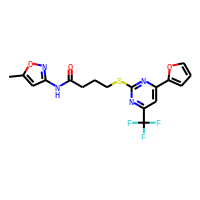

In [9]:
moldf.head(1)

In [10]:

def calcfp(mol,funcFPInfo=dict(radius=3,nBits=2048,useFeatures=False,useChirality = False)):
    arr = np.zeros((1,))
    fp = GetMorganFingerprintAsBitVect(mol, **funcFPInfo)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

moldf['Descriptors'] = moldf.Mol.apply(calcfp)
X = np.array(list(moldf['Descriptors'])).astype(int)
X.shape

(5, 2048)

In [16]:
print('Loading models... \n')
with gzip.open('models/beta-lactamase/model_agg_RF_Morgan_balanced_v4.pkl.gz', 'rb') as f:
    beta_lactamase_model = cPickle.load(f)
    
with bz2.BZ2File('models/beta-lactamase/model_agg_RF_Morgan_balanced_v4.pkl.pbz2', 'rb') as f:
    beta_lactamase_model_data = cPickle.load(f)
beta_lactamase_model_fps = np.vstack(beta_lactamase_model_data['fpDF']['FingerPrint'].values)
beta_lactamase_model_AD_limit = (np.average(beta_lactamase_model_data['applM'])-(1*(np.std(beta_lactamase_model_data['applM']))))
print('Beta lactamase model loaded.')
del beta_lactamase_model_data

with gzip.open('models/cruzain/cruzain_agg_RF_Morgan_balanced_v4.pkl.gz', 'rb') as f:
    cruzain_model = cPickle.load(f)
    
with bz2.BZ2File('models/cruzain/cruzain_model_agg_RF_Morgan_balanced_v4.pbz2', 'rb') as f:
    cruzain_model_data = cPickle.load(f)
cruzain_model_fps = np.vstack(cruzain_model_data['fpDF']['FingerPrint'].values)
cruzain_model_AD_limit = (np.average(cruzain_model_data['applM'])-(1*(np.std(cruzain_model_data['applM']))))
print('Cruzain model loaded.')
del cruzain_model_data

Loading models... 

Beta lactamase model loaded.
Cruzain model loaded.


In [12]:
!wget https://ndownloader.figshare.com/articles/11958807?private_link=bcf12452709c1fac3a58

--2020-04-19 16:14:32--  https://ndownloader.figshare.com/articles/11958807?private_link=bcf12452709c1fac3a58
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 54.77.192.93, 18.200.62.117
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|54.77.192.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 450615357 (430M) [application/zip]
Saving to: ‘11958807?private_link=bcf12452709c1fac3a58’

11958807?private_li 100%[===================>] 429.74M  20.5MB/s    in 23s     

2020-04-19 16:14:56 (18.8 MB/s) - ‘11958807?private_link=bcf12452709c1fac3a58’ saved [450615357/450615357]



In [13]:
!unzip jadu.zip

Archive:  jadu.zip
 extracting: datasets.zip            
 extracting: models.zip              


In [14]:
!unzip models.zip

Archive:  models.zip
   creating: models/
   creating: models/beta-lactamase/
  inflating: models/beta-lactamase/desktop.ini  
  inflating: models/beta-lactamase/model_agg_RF_Morgan_balanced_v4.pkl.gz  
  inflating: models/beta-lactamase/model_agg_RF_Morgan_balanced_v4.pkl.pbz2  
   creating: models/cruzain/
  inflating: models/cruzain/cruzain_agg_RF_Morgan_balanced_v4.pkl.gz  
  inflating: models/cruzain/cruzain_model_agg_RF_Morgan_balanced_v4.pbz2  
  inflating: models/cruzain/desktop.ini  
  inflating: models/desktop.ini      


In [15]:
!unzip datasets.zip

Archive:  datasets.zip
   creating: datasets/beta-lactamase/
  inflating: datasets/beta-lactamase/beta_lactamase_balanced_data.sdf.gz  
  inflating: datasets/beta-lactamase/beta_lactamase_ext_data.sdf.gz  
  inflating: datasets/beta-lactamase/beta_lactamase_unbalanced_data.sdf.gz  
   creating: datasets/cruzain/
  inflating: datasets/cruzain/balanced_data.sdf.gz  
  inflating: datasets/cruzain/ext_data.sdf.gz  
  inflating: datasets/cruzain/unbalanced_data.sdf.gz  


In [17]:
print('Predicting SCAMs...')
y_pred_beta = beta_lactamase_model.predict(X)
y_pred_cruzain = cruzain_model.predict(X)

Predicting SCAMs...


In [18]:
print('Estimating applicability domain...')
calc_AD_beta = np.apply_along_axis(calc_AD, 1, X, beta_lactamase_model_fps, beta_lactamase_model_AD_limit)
calc_AD_cruzain = np.apply_along_axis(calc_AD, 1, X, cruzain_model_fps, cruzain_model_AD_limit)

# Beta-lactamase applicability domain
pred_beta = pd.DataFrame({'beta_lactamase': y_pred_beta,'beta_AD': calc_AD_beta}, index=None)
pred_beta.beta_AD[pred_beta.beta_AD == False] = np.nan
pred_beta.beta_AD[pred_beta.beta_AD == True] = pred_beta.beta_lactamase.astype(int)
pred_beta_ad = pred_beta.drop(pred_beta[pred_beta['beta_AD'] == 'Outside AD'].index).reset_index(drop=True)
coverage_ad = len(pred_beta_ad) * 100 / len(pred_beta)

# Cruzain applicability domain
pred_cruzain = pd.DataFrame({'cruzain': y_pred_cruzain,'cruzain_AD': calc_AD_cruzain}, index=None)
pred_cruzain.cruzain_AD[pred_cruzain.cruzain_AD == False] = np.nan
pred_cruzain.cruzain_AD[pred_cruzain.cruzain_AD == True] = pred_cruzain.cruzain.astype(int)
pred_cruzain_ad = pred_cruzain.drop(pred_cruzain[pred_cruzain['cruzain_AD'] == 'Outside AD'].index).reset_index(drop=True)
coverage_ad = len(pred_cruzain_ad) * 100 / len(pred_cruzain)

Estimating applicability domain...


,InChIKey,SMILES,ID,Mol,beta_lactamase,beta_AD,cruzain,cruzain_AD
0,WZXRSGMXJJLRNL-UHFFFAOYSA-N,Cc1cc(NC(=O)CCCSc2nc(-c3ccco3)cc(C(F)(F)F)n2)no1,,,1,Inside AD,1,Inside AD
1,NGMGFRRMBXLNNS-UHFFFAOYSA-N,Cc1ccc(CSc2nc3ccncc3n2CC(=O)Nc2cc(C)cc(C)c2)cc1,,,1,Inside AD,1,Inside AD
2,NWUXAQZDESOKKL-MFKUBSTISA-N,COc1ccc(Br)cc1/C=N/NC(=O)c1nc(-c2ccccc2)n2c1CC...,,,1,Inside AD,1,Inside AD
3,NIJNUARVFJGCOA-UHFFFAOYNA-N,C=CCOc1cccc(C2c3c(oc4ccccc4c3=O)C(=O)N2c2ccccn...,,,0,Inside AD,0,Inside AD
4,FOYOYADXADLUCK-UHFFFAOYNA-N,O=C1OCCN1C(=O)C1C(c2ccccc2)C(c2cccc(Cl)c2)=NN1...,,,1,Outside AD,1,Inside AD

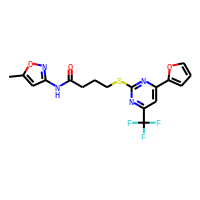
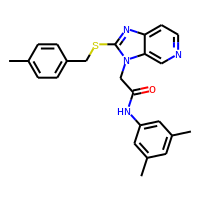
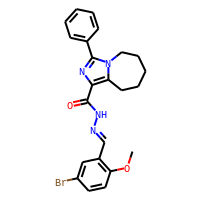
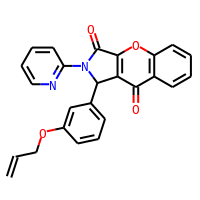
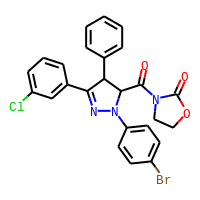

In [19]:
predictions = pd.concat([moldf, pred_beta, pred_cruzain], axis=1)
predictions.drop(columns='Descriptors', inplace=True)
predictions.head()

In [0]:

PandasTools.WriteSDF(predictions, 'predictions.sdf',
                     molColName='Mol', properties=list(predictions.columns))

Generating maps with predicted fragment contribution for beta-lactamase...


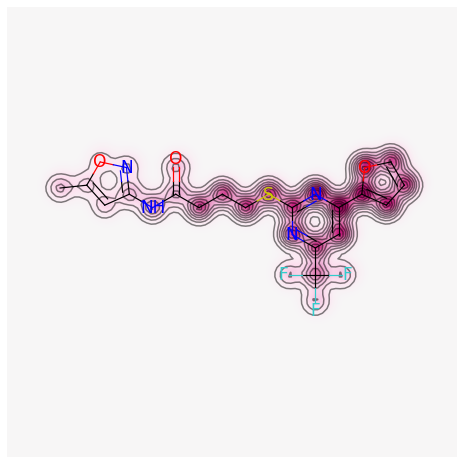

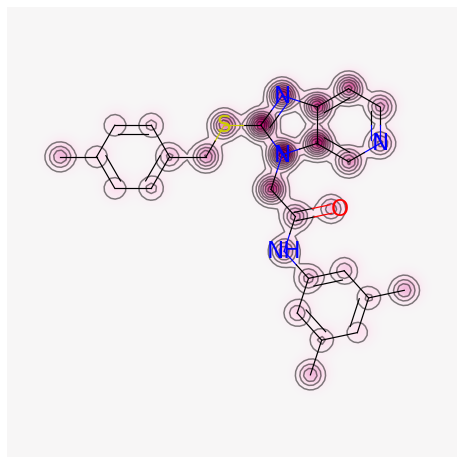

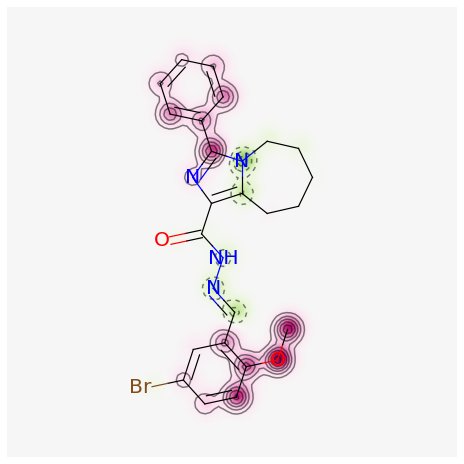

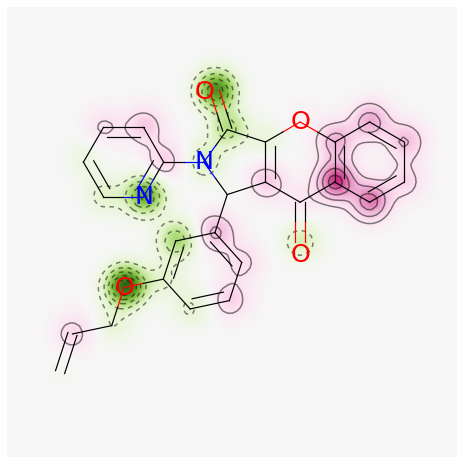

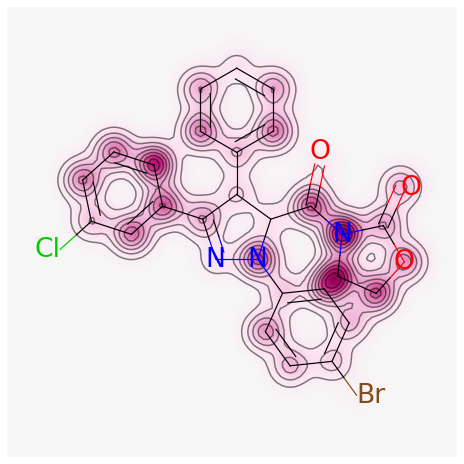

In [21]:
print('Generating maps with predicted fragment contribution for beta-lactamase...')
for i, mol in zip(range(len(moldf.Mol)), moldf.Mol):
    pred_frag(mol, beta_lactamase_model)
    plt.savefig('maps/mol_' + str(i) + '_beta-lactamase.png', bbox_inches='tight')

Generating maps with predicted fragment contribution for cruzain...


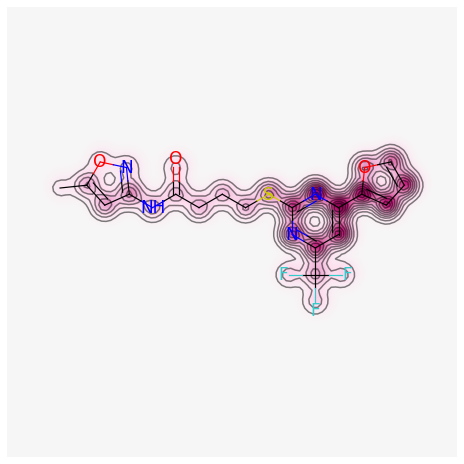

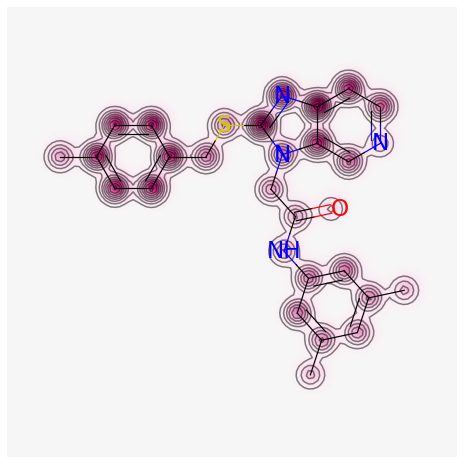

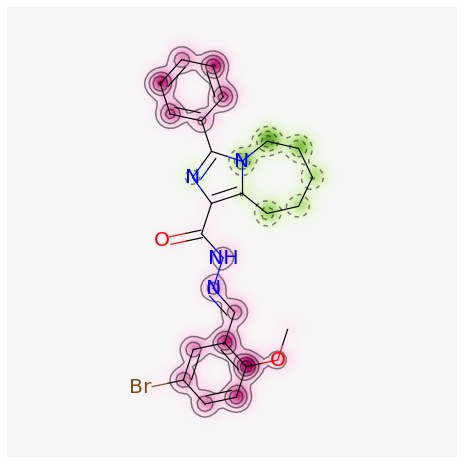

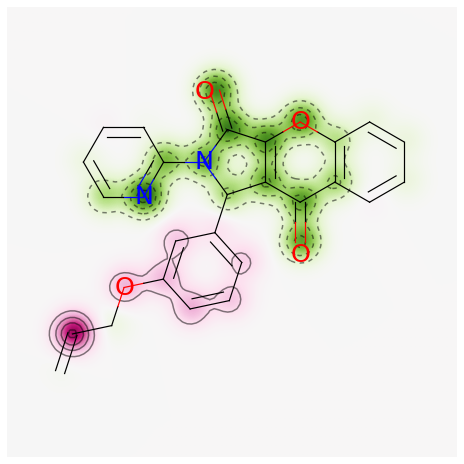

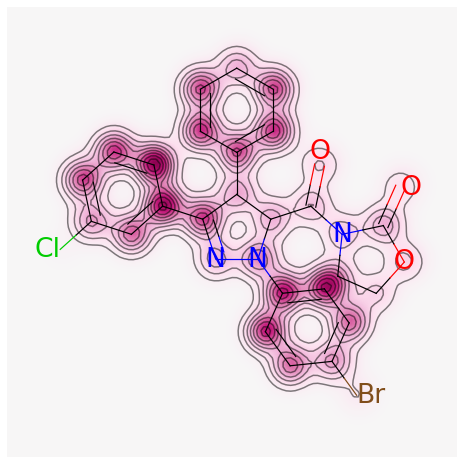

In [22]:

print('Generating maps with predicted fragment contribution for cruzain...')
for i, mol in zip(range(len(moldf.Mol)), moldf.Mol):
    pred_frag(mol, cruzain_model)
    plt.savefig('maps/mol_' + str(i) + '_cruzain.png', bbox_inches='tight')